# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['train_tfrecords',
 'train_images',
 'test_images',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'test_tfrecords']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3

train_id = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")["image_id"]
dist = pd.read_csv("distillation_label/ensemble-v3.csv", header=None)
train_label = pd.DataFrame(dist.idxmax(axis=1), columns=["label"])
train = pd.concat([train_id, train_label, dist], axis=1)

test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")

display(train.head())
display(test.head())
display(label_map)

,image_id,label,0,1,2,3,4
0,1000015157.jpg,0,0.373521,0.296580,0.124931,0.018632,0.186336
1,1000201771.jpg,3,0.020839,0.027160,0.037688,0.886378,0.027935
2,100042118.jpg,4,0.028102,0.335759,0.043405,0.054358,0.538376
3,1000723321.jpg,1,0.021610,0.843521,0.029899,0.046169,0.058801
4,1000812911.jpg,3,0.023698,0.019814,0.022040,0.913077,0.021371


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

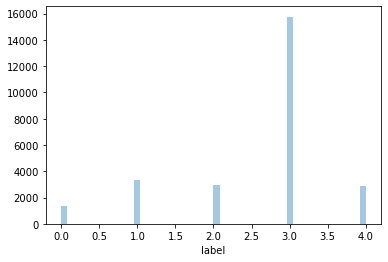

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = True
    print_freq = 100
    num_workers = 4
    model_name = "tf_efficientnet_b4_ns"  # resnext50_32x4d, seresnext50_32x4d, tf_efficientnet_b3_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 16
    gradient_accumulation_steps = 2
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.2
    kd_temperature = 10  # DistillationLoss
    kd_alpha = 0.9  # DistillationLoss
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    )  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 5345
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         279
      1         671
      2         590
      3        3153
      4         575
1     0         278
      1         671
      2         590
      3        3154
      4         575
2     0         278
      1         672
      2         589
      3        3153
      4         575
3     0         278
      1         672
      2         589
      3        3153
      4         575
4     0         278
      1         672
      2         589
      3        3153
      4         575
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.hard_target = df["label"].values
        self.soft_target = df[[0, 1, 2, 3, 4]].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        hard_target = torch.tensor(self.hard_target[idx]).long()
        soft_target = torch.tensor(self.soft_target[idx]).float()
        return image, hard_target, soft_target


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

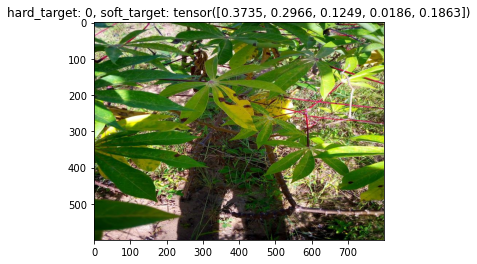

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, hard_target, soft_target = train_dataset[i]
    plt.imshow(image)
    plt.title(f"hard_target: {hard_target}, soft_target: {soft_target}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                CenterCrop(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

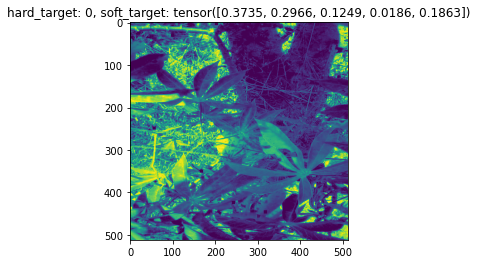

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, hard_target, soft_target = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"hard_target: {hard_target}, soft_target: {soft_target}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, soft_target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]
    shuffled_soft_target = soft_target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, soft_target, shuffled_target, shuffled_soft_target, lam)

    return new_data, targets


def fmix(data, targets, soft_target, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    shuffled_soft_target = soft_target[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, soft_target, shuffled_targets, shuffled_soft_target, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, soft_target, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    shuffled_soft_target = soft_target[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, soft_target, y_b, shuffled_soft_target, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if "resnext50_32x4d" in model_name:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    if CFG.model_name.startswith("vit_"):
        try:
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                    m.eval()
        except ValuError:
            print("error with batchnorm2d or layernorm")
            return

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
# print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, hard_target, soft_target in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.3405,  0.1432,  0.1180, -0.1272,  0.0600],
        [-0.0630,  0.0255, -0.1061,  0.0779, -0.0010],
        [ 0.0283,  0.0761, -0.0753,  0.0680,  0.0644],
        [ 0.0899,  0.0703, -0.0103, -0.0237,  0.0643]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

In [20]:
class DistillationLoss(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.criterion = criterion
        self.alpha = CFG.kd_alpha
        self.T = CFG.kd_temperature

    # https://github.com/peterliht/knowledge-distillation-pytorch/blob/b1e4b6acb8d4e138ad12ba1aac22d5da42a85c10/model/net.py#L100
    def forward(self, outputs, hard_target, soft_target):
        """
        Compute the knowledge-distillation (KD) loss given outputs, labels.
        "Hyperparameters": temperature and alpha
        NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
        and student expects the input tensor to be log probabilities! See Issue #2
        """
        KD_loss = nn.KLDivLoss()(F.log_softmax(outputs / self.T, dim=1), F.softmax(soft_target / self.T, dim=1)) * (
            self.alpha * self.T * self.T
        ) + self.criterion(outputs, hard_target) * (1.0 - self.alpha)

        return KD_loss

# Helper functions

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, hard_target, soft_target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        hard_target = hard_target.to(device)
        soft_target = soft_target.to(device)
        batch_size = hard_target.shape[0]

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, hard_target, soft_target, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(
                images, hard_target, soft_target, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size)
            )
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, hard_target, soft_target, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0], labels[1]) * labels[4] + criterion(y_preds, labels[2], labels[3]) * (
                1.0 - labels[4]
            )
        else:
            loss = criterion(y_preds, hard_target, soft_target)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, hard_target, soft_target) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        hard_target = hard_target.to(device)
        soft_target = soft_target.to(device)
        batch_size = hard_target.shape[0]
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, hard_target, soft_target)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [22]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            hard_criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            hard_criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)

        criterion = DistillationLoss(hard_criterion)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [23]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [24]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


Epoch: [1][0/1316] Elapsed 0m 8s (remain 191m 44s) Loss: 0.0409(0.0409) Grad: 0.0555 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 40s (remain 8m 8s) Loss: 0.0284(0.0289) Grad: 0.0466 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 11s (remain 6m 38s) Loss: 0.0200(0.0264) Grad: 0.0388 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 43s (remain 5m 48s) Loss: 0.0207(0.0247) Grad: 0.0428 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 14s (remain 5m 7s) Loss: 0.0204(0.0236) Grad: 0.0366 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 46s (remain 4m 30s) Loss: 0.0196(0.0227) Grad: 0.0358 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 17s (remain 3m 55s) Loss: 0.0151(0.0219) Grad: 0.0205 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 48s (remain 3m 20s) Loss: 0.0177(0.0215) Grad: 0.0315 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 20s (remain 2m 47s) Loss: 0.0174(0.0211) Grad: 0.0216 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 51s (remain 2m 14s) Loss: 0.0152(0.0207) Grad: 0.0172 LR: 0.00

Epoch 1 - avg_train_loss: 0.0195  avg_val_loss: 0.0159  time: 483s
Epoch 1 - Accuracy: 0.9316628701594533
Epoch 1 - Save Best Score: 0.9317 Model


EVAL: [329/330] Elapsed 1m 0s (remain 0m 0s) Loss: 0.0193(0.0159) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 24m 53s) Loss: 0.0167(0.0167) Grad: 0.0232 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 31s (remain 6m 18s) Loss: 0.0148(0.0157) Grad: 0.0158 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 2s (remain 5m 45s) Loss: 0.0155(0.0155) Grad: 0.0220 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 32s (remain 5m 12s) Loss: 0.0154(0.0155) Grad: 0.0199 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 2s (remain 4m 40s) Loss: 0.0154(0.0155) Grad: 0.0196 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 33s (remain 4m 9s) Loss: 0.0148(0.0155) Grad: 0.0227 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 3s (remain 3m 38s) Loss: 0.0135(0.0155) Grad: 0.0169 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 34s (remain 3m 7s) Loss: 0.0147(0.0155) Grad: 0.0169 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 4s (remain 2m 37s) Loss: 0.0159(0.0155) Grad: 0.0232 LR: 0.000094  
Epoch: [2][900/1316] Elapsed 4m 

Epoch 2 - avg_train_loss: 0.0154  avg_val_loss: 0.0153  time: 435s
Epoch 2 - Accuracy: 0.937547456340167
Epoch 2 - Save Best Score: 0.9375 Model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0179(0.0153) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 26m 29s) Loss: 0.0193(0.0193) Grad: 0.0260 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 32s (remain 6m 36s) Loss: 0.0282(0.0239) Grad: 0.0192 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 4s (remain 6m 0s) Loss: 0.0175(0.0240) Grad: 0.0251 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 37s (remain 5m 27s) Loss: 0.0169(0.0235) Grad: 0.0199 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 9s (remain 4m 55s) Loss: 0.0214(0.0232) Grad: 0.0255 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 41s (remain 4m 22s) Loss: 0.0185(0.0231) Grad: 0.0281 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 13s (remain 3m 50s) Loss: 0.0295(0.0230) Grad: 0.0189 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 45s (remain 3m 18s) Loss: 0.0189(0.0231) Grad: 0.0277 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 17s (remain 2m 45s) Loss: 0.0177(0.0230) Grad: 0.0239 LR: 0.000084  
Epoch: [3][900/1316] Elapsed

Epoch 3 - avg_train_loss: 0.0230  avg_val_loss: 0.0160  time: 459s
Epoch 3 - Accuracy: 0.9347000759301443


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0204(0.0160) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 26m 34s) Loss: 0.0139(0.0139) Grad: 0.0212 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 33s (remain 6m 38s) Loss: 0.0278(0.0226) Grad: 0.0244 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 5s (remain 6m 2s) Loss: 0.0170(0.0225) Grad: 0.0226 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 36s (remain 5m 26s) Loss: 0.0243(0.0225) Grad: 0.0181 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 8s (remain 4m 53s) Loss: 0.0151(0.0224) Grad: 0.0199 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 40s (remain 4m 21s) Loss: 0.0165(0.0223) Grad: 0.0232 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 12s (remain 3m 49s) Loss: 0.0323(0.0222) Grad: 0.0147 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 3m 44s (remain 3m 17s) Loss: 0.0296(0.0221) Grad: 0.0162 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 16s (remain 2m 45s) Loss: 0.0219(0.0221) Grad: 0.0195 LR: 0.000072  
Epoch: [4][900/1316] Elapsed

Epoch 4 - avg_train_loss: 0.0221  avg_val_loss: 0.0157  time: 458s
Epoch 4 - Accuracy: 0.9345102505694761


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0247(0.0157) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 27m 10s) Loss: 0.0152(0.0152) Grad: 0.0189 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 33s (remain 6m 38s) Loss: 0.0260(0.0225) Grad: 0.0245 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 5s (remain 6m 3s) Loss: 0.0142(0.0221) Grad: 0.0104 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 37s (remain 5m 29s) Loss: 0.0260(0.0222) Grad: 0.0143 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 9s (remain 4m 55s) Loss: 0.0284(0.0219) Grad: 0.0213 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 41s (remain 4m 22s) Loss: 0.0221(0.0217) Grad: 0.0297 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 13s (remain 3m 49s) Loss: 0.0273(0.0219) Grad: 0.0138 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 3m 44s (remain 3m 17s) Loss: 0.0289(0.0218) Grad: 0.0267 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 16s (remain 2m 45s) Loss: 0.0156(0.0218) Grad: 0.0201 LR: 0.000057  
Epoch: [5][900/1316] Elapsed

Epoch 5 - avg_train_loss: 0.0218  avg_val_loss: 0.0155  time: 456s
Epoch 5 - Accuracy: 0.9386864085041762
Epoch 5 - Save Best Score: 0.9387 Model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0196(0.0155) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 27m 14s) Loss: 0.0236(0.0236) Grad: 0.0135 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 33s (remain 6m 40s) Loss: 0.0303(0.0225) Grad: 0.0249 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 5s (remain 6m 1s) Loss: 0.0190(0.0221) Grad: 0.0129 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 36s (remain 5m 26s) Loss: 0.0230(0.0220) Grad: 0.0156 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 8s (remain 4m 53s) Loss: 0.0246(0.0219) Grad: 0.0165 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 40s (remain 4m 20s) Loss: 0.0276(0.0220) Grad: 0.0220 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 11s (remain 3m 48s) Loss: 0.0241(0.0218) Grad: 0.0324 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 3m 43s (remain 3m 16s) Loss: 0.0213(0.0218) Grad: 0.0302 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 15s (remain 2m 44s) Loss: 0.0139(0.0217) Grad: 0.0121 LR: 0.000042  
Epoch: [6][900/1316] Elapsed

Epoch 6 - avg_train_loss: 0.0219  avg_val_loss: 0.0152  time: 456s
Epoch 6 - Accuracy: 0.9424829157175398
Epoch 6 - Save Best Score: 0.9425 Model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0196(0.0152) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 28m 0s) Loss: 0.0211(0.0211) Grad: 0.0251 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 33s (remain 6m 38s) Loss: 0.0126(0.0185) Grad: 0.0115 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 4s (remain 5m 56s) Loss: 0.0191(0.0180) Grad: 0.0258 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 35s (remain 5m 21s) Loss: 0.0299(0.0181) Grad: 0.0170 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 6s (remain 4m 48s) Loss: 0.0135(0.0183) Grad: 0.0117 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 37s (remain 4m 16s) Loss: 0.0223(0.0185) Grad: 0.0181 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 9s (remain 3m 45s) Loss: 0.0258(0.0184) Grad: 0.0200 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 40s (remain 3m 13s) Loss: 0.0211(0.0185) Grad: 0.0337 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 11s (remain 2m 41s) Loss: 0.0175(0.0184) Grad: 0.0223 LR: 0.000027  
Epoch: [7][900/1316] Elapsed 

Epoch 7 - avg_train_loss: 0.0184  avg_val_loss: 0.0149  time: 447s
Epoch 7 - Accuracy: 0.943621867881549
Epoch 7 - Save Best Score: 0.9436 Model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0169(0.0149) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 26m 24s) Loss: 0.0156(0.0156) Grad: 0.0165 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 32s (remain 6m 28s) Loss: 0.0149(0.0180) Grad: 0.0227 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 2s (remain 5m 48s) Loss: 0.0166(0.0176) Grad: 0.0187 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 34s (remain 5m 17s) Loss: 0.0156(0.0179) Grad: 0.0200 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 5s (remain 4m 46s) Loss: 0.0138(0.0182) Grad: 0.0091 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 36s (remain 4m 14s) Loss: 0.0193(0.0184) Grad: 0.0190 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 7s (remain 3m 43s) Loss: 0.0152(0.0183) Grad: 0.0238 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 39s (remain 3m 12s) Loss: 0.0145(0.0183) Grad: 0.0105 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 10s (remain 2m 40s) Loss: 0.0214(0.0183) Grad: 0.0367 LR: 0.000015  
Epoch: [8][900/1316] Elapsed

Epoch 8 - avg_train_loss: 0.0183  avg_val_loss: 0.0150  time: 447s
Epoch 8 - Accuracy: 0.9407744874715261


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0185(0.0150) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 26m 20s) Loss: 0.0254(0.0254) Grad: 0.0215 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 32s (remain 6m 27s) Loss: 0.0136(0.0188) Grad: 0.0158 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 3s (remain 5m 49s) Loss: 0.0189(0.0180) Grad: 0.0155 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 34s (remain 5m 19s) Loss: 0.0194(0.0183) Grad: 0.0254 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 5s (remain 4m 46s) Loss: 0.0136(0.0184) Grad: 0.0109 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 36s (remain 4m 14s) Loss: 0.0261(0.0185) Grad: 0.0173 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 7s (remain 3m 43s) Loss: 0.0142(0.0184) Grad: 0.0192 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 3m 39s (remain 3m 12s) Loss: 0.0140(0.0184) Grad: 0.0238 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 10s (remain 2m 40s) Loss: 0.0159(0.0184) Grad: 0.0174 LR: 0.000007  
Epoch: [9][900/1316] Elapsed

Epoch 9 - avg_train_loss: 0.0183  avg_val_loss: 0.0150  time: 445s
Epoch 9 - Accuracy: 0.9421032649962034


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0183(0.0150) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 24m 4s) Loss: 0.0136(0.0136) Grad: 0.0050 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 31s (remain 6m 15s) Loss: 0.0152(0.0146) Grad: 0.0221 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 1s (remain 5m 38s) Loss: 0.0156(0.0144) Grad: 0.0356 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 30s (remain 5m 6s) Loss: 0.0134(0.0144) Grad: 0.0067 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 1s (remain 4m 36s) Loss: 0.0134(0.0143) Grad: 0.0150 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 31s (remain 4m 5s) Loss: 0.0129(0.0142) Grad: 0.0081 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 1s (remain 3m 35s) Loss: 0.0158(0.0143) Grad: 0.0237 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 31s (remain 3m 5s) Loss: 0.0174(0.0143) Grad: 0.0230 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 1s (remain 2m 34s) Loss: 0.0147(0.0143) Grad: 0.0125 LR: 0.000002  
Epoch: [10][900/1316] El

Epoch 10 - avg_train_loss: 0.0142  avg_val_loss: 0.0149  time: 432s
Epoch 10 - Accuracy: 0.9419134396355353
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0189(0.0149) 


========== fold: 0 result ==========
Score: 0.94362
========== fold: 1 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 23m 59s) Loss: 0.0412(0.0412) Grad: 0.0540 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 32s (remain 6m 26s) Loss: 0.0255(0.0289) Grad: 0.0475 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 3s (remain 5m 51s) Loss: 0.0198(0.0258) Grad: 0.0395 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 34s (remain 5m 17s) Loss: 0.0203(0.0243) Grad: 0.0382 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 5s (remain 4m 46s) Loss: 0.0177(0.0233) Grad: 0.0315 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 36s (remain 4m 14s) Loss: 0.0160(0.0225) Grad: 0.0256 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 7s (remain 3m 43s) Loss: 0.0193(0.0219) Grad: 0.0281 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 38s (remain 3m 12s) Loss: 0.0152(0.0214) Grad: 0.0241 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 9s (remain 2m 40s) Loss: 0.0177(0.0210) Grad: 0.0244 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 41s (remain 2m 9s) Loss: 0.0189(0.0206) Grad: 0.0307 LR: 0.000099

Epoch 1 - avg_train_loss: 0.0195  avg_val_loss: 0.0159  time: 448s
Epoch 1 - Accuracy: 0.9371678056188307
Epoch 1 - Save Best Score: 0.9372 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0130(0.0159) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 23m 41s) Loss: 0.0204(0.0204) Grad: 0.0284 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 32s (remain 6m 32s) Loss: 0.0132(0.0158) Grad: 0.0072 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 3s (remain 5m 53s) Loss: 0.0171(0.0157) Grad: 0.0264 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 34s (remain 5m 20s) Loss: 0.0149(0.0156) Grad: 0.0250 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 6s (remain 4m 47s) Loss: 0.0151(0.0157) Grad: 0.0260 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 37s (remain 4m 16s) Loss: 0.0161(0.0156) Grad: 0.0220 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 8s (remain 3m 44s) Loss: 0.0162(0.0156) Grad: 0.0218 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 39s (remain 3m 12s) Loss: 0.0146(0.0155) Grad: 0.0205 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 11s (remain 2m 41s) Loss: 0.0133(0.0155) Grad: 0.0126 LR: 0.000094  
Epoch: [2][900/1316] Elapsed

Epoch 2 - avg_train_loss: 0.0154  avg_val_loss: 0.0152  time: 449s
Epoch 2 - Accuracy: 0.940584662110858
Epoch 2 - Save Best Score: 0.9406 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0129(0.0152) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 28m 9s) Loss: 0.0191(0.0191) Grad: 0.0377 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 34s (remain 6m 53s) Loss: 0.0299(0.0239) Grad: 0.0311 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 7s (remain 6m 13s) Loss: 0.0301(0.0239) Grad: 0.0194 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 40s (remain 5m 39s) Loss: 0.0277(0.0240) Grad: 0.0155 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 13s (remain 5m 5s) Loss: 0.0170(0.0238) Grad: 0.0213 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 46s (remain 4m 31s) Loss: 0.0246(0.0237) Grad: 0.0148 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 19s (remain 3m 57s) Loss: 0.0302(0.0233) Grad: 0.0171 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 52s (remain 3m 24s) Loss: 0.0298(0.0234) Grad: 0.0291 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 26s (remain 2m 51s) Loss: 0.0176(0.0233) Grad: 0.0265 LR: 0.000084  
Epoch: [3][900/1316] Elapsed

Epoch 3 - avg_train_loss: 0.0230  avg_val_loss: 0.0160  time: 473s
Epoch 3 - Accuracy: 0.9301442672741078


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0133(0.0160) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 28m 43s) Loss: 0.0263(0.0263) Grad: 0.0256 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 34s (remain 6m 59s) Loss: 0.0175(0.0216) Grad: 0.0240 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 8s (remain 6m 19s) Loss: 0.0194(0.0224) Grad: 0.0305 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 41s (remain 5m 43s) Loss: 0.0266(0.0225) Grad: 0.0190 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 14s (remain 5m 7s) Loss: 0.0300(0.0224) Grad: 0.0263 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 47s (remain 4m 33s) Loss: 0.0191(0.0224) Grad: 0.0266 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 21s (remain 3m 59s) Loss: 0.0147(0.0223) Grad: 0.0100 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 3m 54s (remain 3m 25s) Loss: 0.0272(0.0223) Grad: 0.0224 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 27s (remain 2m 52s) Loss: 0.0284(0.0223) Grad: 0.0232 LR: 0.000072  
Epoch: [4][900/1316] Elapse

Epoch 4 - avg_train_loss: 0.0222  avg_val_loss: 0.0152  time: 475s
Epoch 4 - Accuracy: 0.9438116932422171
Epoch 4 - Save Best Score: 0.9438 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0126(0.0152) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 26m 22s) Loss: 0.0190(0.0190) Grad: 0.0229 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 34s (remain 6m 52s) Loss: 0.0347(0.0225) Grad: 0.0353 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 7s (remain 6m 13s) Loss: 0.0154(0.0219) Grad: 0.0201 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 40s (remain 5m 39s) Loss: 0.0249(0.0218) Grad: 0.0229 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 13s (remain 5m 5s) Loss: 0.0139(0.0216) Grad: 0.0153 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 46s (remain 4m 31s) Loss: 0.0231(0.0217) Grad: 0.0188 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 19s (remain 3m 57s) Loss: 0.0293(0.0218) Grad: 0.0256 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 3m 52s (remain 3m 24s) Loss: 0.0219(0.0218) Grad: 0.0233 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 26s (remain 2m 51s) Loss: 0.0239(0.0218) Grad: 0.0195 LR: 0.000057  
Epoch: [5][900/1316] Elapse

Epoch 5 - avg_train_loss: 0.0219  avg_val_loss: 0.0152  time: 474s
Epoch 5 - Accuracy: 0.9500759301442673
Epoch 5 - Save Best Score: 0.9501 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0130(0.0152) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 28m 53s) Loss: 0.0289(0.0289) Grad: 0.0161 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 34s (remain 6m 51s) Loss: 0.0196(0.0206) Grad: 0.0188 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 7s (remain 6m 13s) Loss: 0.0159(0.0210) Grad: 0.0290 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 39s (remain 5m 36s) Loss: 0.0259(0.0210) Grad: 0.0155 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 13s (remain 5m 3s) Loss: 0.0158(0.0212) Grad: 0.0215 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 46s (remain 4m 30s) Loss: 0.0318(0.0213) Grad: 0.0198 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 19s (remain 3m 57s) Loss: 0.0132(0.0214) Grad: 0.0100 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 3m 52s (remain 3m 24s) Loss: 0.0230(0.0213) Grad: 0.0190 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 26s (remain 2m 51s) Loss: 0.0194(0.0214) Grad: 0.0086 LR: 0.000042  
Epoch: [6][900/1316] Elapse

Epoch 6 - avg_train_loss: 0.0215  avg_val_loss: 0.0150  time: 473s
Epoch 6 - Accuracy: 0.9502657555049354
Epoch 6 - Save Best Score: 0.9503 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0124(0.0150) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 28m 40s) Loss: 0.0151(0.0151) Grad: 0.0143 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 33s (remain 6m 48s) Loss: 0.0203(0.0198) Grad: 0.0260 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 6s (remain 6m 11s) Loss: 0.0152(0.0189) Grad: 0.0193 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 39s (remain 5m 34s) Loss: 0.0149(0.0187) Grad: 0.0175 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 12s (remain 5m 1s) Loss: 0.0153(0.0186) Grad: 0.0207 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 44s (remain 4m 27s) Loss: 0.0134(0.0186) Grad: 0.0136 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 16s (remain 3m 54s) Loss: 0.0244(0.0186) Grad: 0.0151 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 49s (remain 3m 21s) Loss: 0.0144(0.0186) Grad: 0.0176 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 21s (remain 2m 48s) Loss: 0.0150(0.0187) Grad: 0.0202 LR: 0.000027  
Epoch: [7][900/1316] Elapse

Epoch 7 - avg_train_loss: 0.0186  avg_val_loss: 0.0148  time: 465s
Epoch 7 - Accuracy: 0.9498861047835991


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0126(0.0148) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 29m 7s) Loss: 0.0320(0.0320) Grad: 0.0245 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 33s (remain 6m 47s) Loss: 0.0173(0.0188) Grad: 0.0226 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 6s (remain 6m 9s) Loss: 0.0151(0.0186) Grad: 0.0182 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 39s (remain 5m 34s) Loss: 0.0149(0.0186) Grad: 0.0226 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 11s (remain 5m 0s) Loss: 0.0252(0.0186) Grad: 0.0331 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 43s (remain 4m 26s) Loss: 0.0179(0.0185) Grad: 0.0337 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 16s (remain 3m 53s) Loss: 0.0141(0.0184) Grad: 0.0199 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 48s (remain 3m 20s) Loss: 0.0194(0.0183) Grad: 0.0112 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 20s (remain 2m 47s) Loss: 0.0134(0.0183) Grad: 0.0069 LR: 0.000015  
Epoch: [8][900/1316] Elapsed 

Epoch 8 - avg_train_loss: 0.0185  avg_val_loss: 0.0149  time: 465s
Epoch 8 - Accuracy: 0.9519741837509491
Epoch 8 - Save Best Score: 0.9520 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0128(0.0149) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 28m 6s) Loss: 0.0132(0.0132) Grad: 0.0072 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 33s (remain 6m 47s) Loss: 0.0273(0.0185) Grad: 0.0207 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 6s (remain 6m 9s) Loss: 0.0146(0.0184) Grad: 0.0106 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 39s (remain 5m 34s) Loss: 0.0130(0.0187) Grad: 0.0052 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 11s (remain 5m 0s) Loss: 0.0151(0.0185) Grad: 0.0217 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 44s (remain 4m 27s) Loss: 0.0152(0.0184) Grad: 0.0178 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 16s (remain 3m 54s) Loss: 0.0135(0.0185) Grad: 0.0137 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 3m 49s (remain 3m 21s) Loss: 0.0160(0.0185) Grad: 0.0207 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 22s (remain 2m 48s) Loss: 0.0150(0.0184) Grad: 0.0184 LR: 0.000007  
Epoch: [9][900/1316] Elapsed 

Epoch 9 - avg_train_loss: 0.0184  avg_val_loss: 0.0147  time: 467s
Epoch 9 - Accuracy: 0.9527334851936219
Epoch 9 - Save Best Score: 0.9527 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0126(0.0147) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 23m 37s) Loss: 0.0142(0.0142) Grad: 0.0157 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 32s (remain 6m 29s) Loss: 0.0139(0.0143) Grad: 0.0110 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 3s (remain 5m 52s) Loss: 0.0128(0.0143) Grad: 0.0074 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 34s (remain 5m 19s) Loss: 0.0144(0.0143) Grad: 0.0160 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 6s (remain 4m 47s) Loss: 0.0125(0.0143) Grad: 0.0066 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 37s (remain 4m 15s) Loss: 0.0141(0.0143) Grad: 0.0205 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 8s (remain 3m 44s) Loss: 0.0148(0.0143) Grad: 0.0139 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 39s (remain 3m 12s) Loss: 0.0128(0.0143) Grad: 0.0059 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 11s (remain 2m 41s) Loss: 0.0154(0.0142) Grad: 0.0297 LR: 0.000002  
Epoch: [10][900/131

Epoch 10 - avg_train_loss: 0.0142  avg_val_loss: 0.0146  time: 449s
Epoch 10 - Accuracy: 0.951784358390281
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0125(0.0146) 


========== fold: 1 result ==========
Score: 0.95273
========== fold: 2 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 23m 6s) Loss: 0.0444(0.0444) Grad: 0.0795 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 33s (remain 6m 43s) Loss: 0.0234(0.0303) Grad: 0.0368 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 5s (remain 6m 5s) Loss: 0.0246(0.0272) Grad: 0.0424 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 38s (remain 5m 31s) Loss: 0.0188(0.0251) Grad: 0.0309 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 10s (remain 4m 58s) Loss: 0.0183(0.0238) Grad: 0.0324 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 43s (remain 4m 25s) Loss: 0.0190(0.0230) Grad: 0.0327 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 15s (remain 3m 52s) Loss: 0.0188(0.0222) Grad: 0.0316 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 48s (remain 3m 20s) Loss: 0.0170(0.0217) Grad: 0.0236 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 20s (remain 2m 47s) Loss: 0.0196(0.0213) Grad: 0.0281 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 53s (remain 2m 15s) Loss: 0.0161(0.0208) Grad: 0.0258 LR: 0.0000

Epoch 1 - avg_train_loss: 0.0196  avg_val_loss: 0.0156  time: 466s
Epoch 1 - Accuracy: 0.9382950446174293
Epoch 1 - Save Best Score: 0.9383 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0118(0.0156) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 23m 13s) Loss: 0.0153(0.0153) Grad: 0.0221 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 33s (remain 6m 46s) Loss: 0.0184(0.0156) Grad: 0.0312 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 6s (remain 6m 9s) Loss: 0.0190(0.0156) Grad: 0.0303 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 39s (remain 5m 35s) Loss: 0.0151(0.0156) Grad: 0.0166 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 11s (remain 5m 0s) Loss: 0.0142(0.0156) Grad: 0.0159 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 44s (remain 4m 27s) Loss: 0.0182(0.0156) Grad: 0.0261 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 17s (remain 3m 54s) Loss: 0.0134(0.0156) Grad: 0.0105 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 49s (remain 3m 21s) Loss: 0.0170(0.0155) Grad: 0.0264 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 22s (remain 2m 48s) Loss: 0.0166(0.0154) Grad: 0.0207 LR: 0.000094  
Epoch: [2][900/1316] Elapsed

Epoch 2 - avg_train_loss: 0.0154  avg_val_loss: 0.0153  time: 467s
Epoch 2 - Accuracy: 0.9400037972280235
Epoch 2 - Save Best Score: 0.9400 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0118(0.0153) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 26m 24s) Loss: 0.0342(0.0342) Grad: 0.0378 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 36s (remain 7m 15s) Loss: 0.0154(0.0242) Grad: 0.0211 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 10s (remain 6m 32s) Loss: 0.0251(0.0235) Grad: 0.0189 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 45s (remain 5m 54s) Loss: 0.0191(0.0234) Grad: 0.0231 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 19s (remain 5m 18s) Loss: 0.0169(0.0233) Grad: 0.0203 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 53s (remain 4m 42s) Loss: 0.0217(0.0232) Grad: 0.0172 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 28s (remain 4m 8s) Loss: 0.0218(0.0231) Grad: 0.0151 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 4m 2s (remain 3m 32s) Loss: 0.0257(0.0231) Grad: 0.0291 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 37s (remain 2m 58s) Loss: 0.0203(0.0230) Grad: 0.0251 LR: 0.000084  
Epoch: [3][900/1316] Elapse

Epoch 3 - avg_train_loss: 0.0227  avg_val_loss: 0.0154  time: 493s
Epoch 3 - Accuracy: 0.9430415796468578
Epoch 3 - Save Best Score: 0.9430 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0118(0.0154) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 30m 11s) Loss: 0.0183(0.0183) Grad: 0.0176 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 36s (remain 7m 21s) Loss: 0.0282(0.0221) Grad: 0.0205 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 11s (remain 6m 35s) Loss: 0.0286(0.0224) Grad: 0.0202 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 46s (remain 5m 59s) Loss: 0.0164(0.0224) Grad: 0.0222 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 21s (remain 5m 22s) Loss: 0.0148(0.0223) Grad: 0.0160 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 55s (remain 4m 46s) Loss: 0.0160(0.0223) Grad: 0.0169 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 30s (remain 4m 10s) Loss: 0.0299(0.0223) Grad: 0.0226 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 4m 4s (remain 3m 34s) Loss: 0.0147(0.0221) Grad: 0.0205 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 38s (remain 2m 59s) Loss: 0.0178(0.0220) Grad: 0.0241 LR: 0.000072  
Epoch: [4][900/1316] Elaps

Epoch 4 - avg_train_loss: 0.0221  avg_val_loss: 0.0152  time: 494s
Epoch 4 - Accuracy: 0.9432314410480349
Epoch 4 - Save Best Score: 0.9432 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0118(0.0152) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 25m 59s) Loss: 0.0193(0.0193) Grad: 0.0195 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 36s (remain 7m 20s) Loss: 0.0251(0.0221) Grad: 0.0189 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 11s (remain 6m 36s) Loss: 0.0243(0.0222) Grad: 0.0187 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 46s (remain 5m 58s) Loss: 0.0167(0.0222) Grad: 0.0177 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 21s (remain 5m 22s) Loss: 0.0222(0.0221) Grad: 0.0186 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 56s (remain 4m 46s) Loss: 0.0165(0.0220) Grad: 0.0217 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 31s (remain 4m 11s) Loss: 0.0248(0.0221) Grad: 0.0159 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 4m 6s (remain 3m 35s) Loss: 0.0261(0.0221) Grad: 0.0160 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 40s (remain 3m 0s) Loss: 0.0142(0.0221) Grad: 0.0201 LR: 0.000057  
Epoch: [5][900/1316] Elapse

Epoch 5 - avg_train_loss: 0.0219  avg_val_loss: 0.0153  time: 495s
Epoch 5 - Accuracy: 0.9470286690715778
Epoch 5 - Save Best Score: 0.9470 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0118(0.0153) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 29m 30s) Loss: 0.0247(0.0247) Grad: 0.0278 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 36s (remain 7m 19s) Loss: 0.0330(0.0224) Grad: 0.0273 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 11s (remain 6m 34s) Loss: 0.0287(0.0222) Grad: 0.0230 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 45s (remain 5m 57s) Loss: 0.0201(0.0220) Grad: 0.0338 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 20s (remain 5m 20s) Loss: 0.0252(0.0217) Grad: 0.0141 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 54s (remain 4m 44s) Loss: 0.0212(0.0217) Grad: 0.0276 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 29s (remain 4m 8s) Loss: 0.0209(0.0217) Grad: 0.0286 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 4m 3s (remain 3m 33s) Loss: 0.0275(0.0216) Grad: 0.0164 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 38s (remain 2m 58s) Loss: 0.0151(0.0216) Grad: 0.0174 LR: 0.000042  
Epoch: [6][900/1316] Elapse

Epoch 6 - avg_train_loss: 0.0216  avg_val_loss: 0.0151  time: 494s
Epoch 6 - Accuracy: 0.9491171444845263
Epoch 6 - Save Best Score: 0.9491 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0118(0.0151) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 28m 4s) Loss: 0.0144(0.0144) Grad: 0.0136 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 35s (remain 7m 7s) Loss: 0.0152(0.0188) Grad: 0.0184 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 9s (remain 6m 23s) Loss: 0.0361(0.0185) Grad: 0.0431 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 43s (remain 5m 48s) Loss: 0.0211(0.0188) Grad: 0.0146 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 17s (remain 5m 13s) Loss: 0.0244(0.0185) Grad: 0.0381 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 51s (remain 4m 38s) Loss: 0.0148(0.0185) Grad: 0.0122 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 25s (remain 4m 4s) Loss: 0.0178(0.0185) Grad: 0.0265 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 59s (remain 3m 30s) Loss: 0.0204(0.0184) Grad: 0.0120 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 33s (remain 2m 55s) Loss: 0.0143(0.0184) Grad: 0.0154 LR: 0.000027  
Epoch: [7][900/1316] Elapsed 

Epoch 7 - avg_train_loss: 0.0184  avg_val_loss: 0.0150  time: 486s
Epoch 7 - Accuracy: 0.9483576988798177


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0118(0.0150) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 28m 8s) Loss: 0.0186(0.0186) Grad: 0.0250 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 35s (remain 7m 7s) Loss: 0.0169(0.0182) Grad: 0.0248 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 9s (remain 6m 26s) Loss: 0.0167(0.0188) Grad: 0.0291 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 43s (remain 5m 47s) Loss: 0.0172(0.0185) Grad: 0.0133 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 16s (remain 5m 12s) Loss: 0.0186(0.0183) Grad: 0.0330 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 50s (remain 4m 37s) Loss: 0.0170(0.0184) Grad: 0.0161 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 24s (remain 4m 3s) Loss: 0.0327(0.0185) Grad: 0.0260 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 59s (remain 3m 29s) Loss: 0.0303(0.0185) Grad: 0.0253 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 32s (remain 2m 55s) Loss: 0.0244(0.0184) Grad: 0.0145 LR: 0.000015  
Epoch: [8][900/1316] Elapsed 

Epoch 8 - avg_train_loss: 0.0183  avg_val_loss: 0.0150  time: 487s
Epoch 8 - Accuracy: 0.9422821340421492


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0118(0.0150) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 27m 2s) Loss: 0.0194(0.0194) Grad: 0.0274 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 35s (remain 7m 12s) Loss: 0.0143(0.0186) Grad: 0.0170 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 10s (remain 6m 30s) Loss: 0.0217(0.0184) Grad: 0.0241 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 44s (remain 5m 52s) Loss: 0.0136(0.0180) Grad: 0.0053 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 18s (remain 5m 16s) Loss: 0.0125(0.0179) Grad: 0.0046 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 52s (remain 4m 40s) Loss: 0.0273(0.0180) Grad: 0.0169 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 26s (remain 4m 5s) Loss: 0.0313(0.0180) Grad: 0.0262 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 4m 0s (remain 3m 30s) Loss: 0.0156(0.0180) Grad: 0.0190 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 34s (remain 2m 56s) Loss: 0.0160(0.0181) Grad: 0.0221 LR: 0.000007  
Epoch: [9][900/1316] Elapsed

Epoch 9 - avg_train_loss: 0.0181  avg_val_loss: 0.0148  time: 487s
Epoch 9 - Accuracy: 0.9494968672868805
Epoch 9 - Save Best Score: 0.9495 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0117(0.0148) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 23m 32s) Loss: 0.0151(0.0151) Grad: 0.0238 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 33s (remain 6m 48s) Loss: 0.0131(0.0145) Grad: 0.0124 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 6s (remain 6m 10s) Loss: 0.0145(0.0143) Grad: 0.0177 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 40s (remain 5m 39s) Loss: 0.0157(0.0143) Grad: 0.0243 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 12s (remain 5m 3s) Loss: 0.0133(0.0142) Grad: 0.0056 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 45s (remain 4m 29s) Loss: 0.0132(0.0142) Grad: 0.0056 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 17s (remain 3m 55s) Loss: 0.0130(0.0142) Grad: 0.0038 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 50s (remain 3m 22s) Loss: 0.0134(0.0142) Grad: 0.0081 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 22s (remain 2m 49s) Loss: 0.0135(0.0142) Grad: 0.0125 LR: 0.000002  
Epoch: [10][900/13

Epoch 10 - avg_train_loss: 0.0141  avg_val_loss: 0.0148  time: 469s
Epoch 10 - Accuracy: 0.9468388076704006
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0118(0.0148) 


========== fold: 2 result ==========
Score: 0.94950
========== fold: 3 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 23m 18s) Loss: 0.0416(0.0416) Grad: 0.0585 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 35s (remain 7m 3s) Loss: 0.0243(0.0292) Grad: 0.0435 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 9s (remain 6m 24s) Loss: 0.0262(0.0262) Grad: 0.0501 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 43s (remain 5m 50s) Loss: 0.0199(0.0242) Grad: 0.0306 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 18s (remain 5m 16s) Loss: 0.0172(0.0234) Grad: 0.0295 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 52s (remain 4m 40s) Loss: 0.0161(0.0224) Grad: 0.0273 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 25s (remain 4m 5s) Loss: 0.0197(0.0218) Grad: 0.0317 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 4m 0s (remain 3m 30s) Loss: 0.0195(0.0213) Grad: 0.0372 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 33s (remain 2m 56s) Loss: 0.0166(0.0209) Grad: 0.0281 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 5m 8s (remain 2m 21s) Loss: 0.0185(0.0205) Grad: 0.0293 LR: 0.000099

Epoch 1 - avg_train_loss: 0.0195  avg_val_loss: 0.0160  time: 487s
Epoch 1 - Accuracy: 0.9251946079362066
Epoch 1 - Save Best Score: 0.9252 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0236(0.0160) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 24m 53s) Loss: 0.0140(0.0140) Grad: 0.0103 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 34s (remain 7m 0s) Loss: 0.0195(0.0156) Grad: 0.0307 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 8s (remain 6m 21s) Loss: 0.0149(0.0155) Grad: 0.0232 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 43s (remain 5m 47s) Loss: 0.0147(0.0155) Grad: 0.0254 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 16s (remain 5m 12s) Loss: 0.0187(0.0154) Grad: 0.0337 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 50s (remain 4m 37s) Loss: 0.0155(0.0155) Grad: 0.0284 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 24s (remain 4m 3s) Loss: 0.0135(0.0155) Grad: 0.0091 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 58s (remain 3m 29s) Loss: 0.0141(0.0154) Grad: 0.0197 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 32s (remain 2m 55s) Loss: 0.0132(0.0154) Grad: 0.0100 LR: 0.000094  
Epoch: [2][900/1316] Elapsed

Epoch 2 - avg_train_loss: 0.0153  avg_val_loss: 0.0156  time: 485s
Epoch 2 - Accuracy: 0.9286121131573951
Epoch 2 - Save Best Score: 0.9286 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0285(0.0156) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 30m 19s) Loss: 0.0314(0.0314) Grad: 0.0424 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 37s (remain 7m 33s) Loss: 0.0197(0.0241) Grad: 0.0274 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 13s (remain 6m 50s) Loss: 0.0147(0.0236) Grad: 0.0144 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 50s (remain 6m 12s) Loss: 0.0320(0.0234) Grad: 0.0238 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 27s (remain 5m 35s) Loss: 0.0178(0.0233) Grad: 0.0253 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 3m 3s (remain 4m 58s) Loss: 0.0261(0.0232) Grad: 0.0336 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 39s (remain 4m 21s) Loss: 0.0241(0.0231) Grad: 0.0147 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 4m 16s (remain 3m 44s) Loss: 0.0195(0.0230) Grad: 0.0159 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 52s (remain 3m 8s) Loss: 0.0288(0.0229) Grad: 0.0229 LR: 0.000084  
Epoch: [3][900/1316] Elapse

Epoch 3 - avg_train_loss: 0.0227  avg_val_loss: 0.0158  time: 518s
Epoch 3 - Accuracy: 0.9360167078033036
Epoch 3 - Save Best Score: 0.9360 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0199(0.0158) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 32m 44s) Loss: 0.0155(0.0155) Grad: 0.0209 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 37s (remain 7m 30s) Loss: 0.0195(0.0222) Grad: 0.0335 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 14s (remain 6m 50s) Loss: 0.0210(0.0219) Grad: 0.0184 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 50s (remain 6m 13s) Loss: 0.0201(0.0223) Grad: 0.0283 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 27s (remain 5m 35s) Loss: 0.0259(0.0222) Grad: 0.0148 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 3m 3s (remain 4m 58s) Loss: 0.0181(0.0222) Grad: 0.0156 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 39s (remain 4m 21s) Loss: 0.0159(0.0221) Grad: 0.0265 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 4m 16s (remain 3m 44s) Loss: 0.0169(0.0221) Grad: 0.0208 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 52s (remain 3m 8s) Loss: 0.0147(0.0221) Grad: 0.0160 LR: 0.000072  
Epoch: [4][900/1316] Elapse

Epoch 4 - avg_train_loss: 0.0221  avg_val_loss: 0.0155  time: 520s
Epoch 4 - Accuracy: 0.9415226884374407
Epoch 4 - Save Best Score: 0.9415 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0223(0.0155) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 29m 35s) Loss: 0.0228(0.0228) Grad: 0.0208 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 37s (remain 7m 35s) Loss: 0.0191(0.0219) Grad: 0.0218 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 15s (remain 6m 56s) Loss: 0.0275(0.0217) Grad: 0.0275 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 51s (remain 6m 14s) Loss: 0.0143(0.0218) Grad: 0.0137 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 27s (remain 5m 37s) Loss: 0.0253(0.0217) Grad: 0.0209 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 3m 4s (remain 4m 59s) Loss: 0.0258(0.0218) Grad: 0.0218 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 41s (remain 4m 23s) Loss: 0.0278(0.0218) Grad: 0.0208 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 4m 17s (remain 3m 45s) Loss: 0.0237(0.0218) Grad: 0.0245 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 53s (remain 3m 8s) Loss: 0.0177(0.0218) Grad: 0.0258 LR: 0.000057  
Epoch: [5][900/1316] Elapse

Epoch 5 - avg_train_loss: 0.0220  avg_val_loss: 0.0157  time: 520s
Epoch 5 - Accuracy: 0.9390544902221378


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0200(0.0157) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 29m 9s) Loss: 0.0148(0.0148) Grad: 0.0169 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 37s (remain 7m 33s) Loss: 0.0199(0.0214) Grad: 0.0209 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 14s (remain 6m 50s) Loss: 0.0372(0.0216) Grad: 0.0424 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 50s (remain 6m 13s) Loss: 0.0210(0.0217) Grad: 0.0204 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 26s (remain 5m 35s) Loss: 0.0282(0.0217) Grad: 0.0165 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 3m 2s (remain 4m 57s) Loss: 0.0208(0.0217) Grad: 0.0325 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 39s (remain 4m 20s) Loss: 0.0186(0.0215) Grad: 0.0290 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 4m 15s (remain 3m 43s) Loss: 0.0309(0.0215) Grad: 0.0192 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 51s (remain 3m 7s) Loss: 0.0156(0.0214) Grad: 0.0235 LR: 0.000042  
Epoch: [6][900/1316] Elapsed

Epoch 6 - avg_train_loss: 0.0215  avg_val_loss: 0.0153  time: 517s
Epoch 6 - Accuracy: 0.9401936586292007


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0180(0.0153) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 27m 27s) Loss: 0.0184(0.0184) Grad: 0.0269 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 37s (remain 7m 31s) Loss: 0.0175(0.0182) Grad: 0.0159 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 12s (remain 6m 44s) Loss: 0.0133(0.0181) Grad: 0.0133 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 48s (remain 6m 6s) Loss: 0.0245(0.0184) Grad: 0.0229 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 24s (remain 5m 29s) Loss: 0.0188(0.0183) Grad: 0.0132 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 3m 0s (remain 4m 53s) Loss: 0.0160(0.0183) Grad: 0.0190 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 36s (remain 4m 18s) Loss: 0.0133(0.0183) Grad: 0.0121 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 4m 12s (remain 3m 41s) Loss: 0.0265(0.0183) Grad: 0.0216 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 48s (remain 3m 5s) Loss: 0.0279(0.0184) Grad: 0.0208 LR: 0.000027  
Epoch: [7][900/1316] Elapsed

Epoch 7 - avg_train_loss: 0.0184  avg_val_loss: 0.0150  time: 511s
Epoch 7 - Accuracy: 0.9424719954433264
Epoch 7 - Save Best Score: 0.9425 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0145(0.0150) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 29m 49s) Loss: 0.0262(0.0262) Grad: 0.0341 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 37s (remain 7m 28s) Loss: 0.0133(0.0188) Grad: 0.0098 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 12s (remain 6m 44s) Loss: 0.0178(0.0189) Grad: 0.0192 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 48s (remain 6m 4s) Loss: 0.0236(0.0188) Grad: 0.0099 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 23s (remain 5m 28s) Loss: 0.0192(0.0185) Grad: 0.0214 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 59s (remain 4m 51s) Loss: 0.0142(0.0184) Grad: 0.0139 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 35s (remain 4m 16s) Loss: 0.0182(0.0186) Grad: 0.0289 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 4m 11s (remain 3m 40s) Loss: 0.0151(0.0185) Grad: 0.0223 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 47s (remain 3m 4s) Loss: 0.0140(0.0186) Grad: 0.0141 LR: 0.000015  
Epoch: [8][900/1316] Elapse

Epoch 8 - avg_train_loss: 0.0186  avg_val_loss: 0.0149  time: 509s
Epoch 8 - Accuracy: 0.9447503322574521
Epoch 8 - Save Best Score: 0.9448 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0134(0.0149) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 29m 37s) Loss: 0.0161(0.0161) Grad: 0.0206 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 37s (remain 7m 27s) Loss: 0.0172(0.0181) Grad: 0.0205 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 12s (remain 6m 44s) Loss: 0.0239(0.0185) Grad: 0.0164 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 48s (remain 6m 5s) Loss: 0.0170(0.0185) Grad: 0.0245 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 23s (remain 5m 28s) Loss: 0.0208(0.0184) Grad: 0.0250 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 58s (remain 4m 51s) Loss: 0.0176(0.0183) Grad: 0.0275 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 34s (remain 4m 15s) Loss: 0.0173(0.0184) Grad: 0.0300 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 4m 10s (remain 3m 39s) Loss: 0.0156(0.0183) Grad: 0.0219 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 46s (remain 3m 4s) Loss: 0.0138(0.0183) Grad: 0.0091 LR: 0.000007  
Epoch: [9][900/1316] Elapse

Epoch 9 - avg_train_loss: 0.0183  avg_val_loss: 0.0148  time: 508s
Epoch 9 - Accuracy: 0.9483576988798177
Epoch 9 - Save Best Score: 0.9484 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0153(0.0148) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 26m 50s) Loss: 0.0157(0.0157) Grad: 0.0257 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 35s (remain 7m 5s) Loss: 0.0158(0.0145) Grad: 0.0152 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 9s (remain 6m 25s) Loss: 0.0181(0.0144) Grad: 0.0282 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 43s (remain 5m 47s) Loss: 0.0123(0.0143) Grad: 0.0023 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 17s (remain 5m 13s) Loss: 0.0143(0.0143) Grad: 0.0081 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 50s (remain 4m 38s) Loss: 0.0147(0.0142) Grad: 0.0239 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 24s (remain 4m 3s) Loss: 0.0126(0.0142) Grad: 0.0059 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 59s (remain 3m 30s) Loss: 0.0129(0.0142) Grad: 0.0046 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 33s (remain 2m 55s) Loss: 0.0157(0.0142) Grad: 0.0225 LR: 0.000002  
Epoch: [10][900/131

Epoch 10 - avg_train_loss: 0.0141  avg_val_loss: 0.0148  time: 487s
Epoch 10 - Accuracy: 0.9441807480539206
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0151(0.0148) 


========== fold: 3 result ==========
Score: 0.94836
========== fold: 4 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 24m 15s) Loss: 0.0467(0.0467) Grad: 0.0773 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 36s (remain 7m 22s) Loss: 0.0202(0.0293) Grad: 0.0315 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 12s (remain 6m 42s) Loss: 0.0256(0.0263) Grad: 0.0471 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 48s (remain 6m 5s) Loss: 0.0279(0.0246) Grad: 0.0522 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 23s (remain 5m 28s) Loss: 0.0169(0.0235) Grad: 0.0281 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 59s (remain 4m 51s) Loss: 0.0225(0.0227) Grad: 0.0375 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 34s (remain 4m 15s) Loss: 0.0162(0.0221) Grad: 0.0224 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 4m 10s (remain 3m 39s) Loss: 0.0156(0.0215) Grad: 0.0212 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 45s (remain 3m 3s) Loss: 0.0167(0.0211) Grad: 0.0274 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 5m 21s (remain 2m 28s) Loss: 0.0162(0.0207) Grad: 0.0281 LR: 0.000

Epoch 1 - avg_train_loss: 0.0196  avg_val_loss: 0.0157  time: 509s
Epoch 1 - Accuracy: 0.9398139358268464
Epoch 1 - Save Best Score: 0.9398 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0153(0.0157) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 24m 16s) Loss: 0.0146(0.0146) Grad: 0.0184 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 36s (remain 7m 21s) Loss: 0.0162(0.0159) Grad: 0.0230 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 12s (remain 6m 40s) Loss: 0.0146(0.0157) Grad: 0.0194 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 47s (remain 6m 3s) Loss: 0.0143(0.0156) Grad: 0.0179 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 23s (remain 5m 27s) Loss: 0.0166(0.0156) Grad: 0.0311 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 59s (remain 4m 51s) Loss: 0.0129(0.0155) Grad: 0.0088 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 34s (remain 4m 15s) Loss: 0.0143(0.0155) Grad: 0.0159 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 4m 10s (remain 3m 39s) Loss: 0.0163(0.0155) Grad: 0.0271 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 45s (remain 3m 3s) Loss: 0.0156(0.0155) Grad: 0.0169 LR: 0.000094  
Epoch: [2][900/1316] Elapse

Epoch 2 - avg_train_loss: 0.0154  avg_val_loss: 0.0153  time: 509s
Epoch 2 - Accuracy: 0.9426618568445035
Epoch 2 - Save Best Score: 0.9427 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0157(0.0153) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 29m 36s) Loss: 0.0184(0.0184) Grad: 0.0287 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 39s (remain 7m 54s) Loss: 0.0299(0.0235) Grad: 0.0226 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 17s (remain 7m 9s) Loss: 0.0263(0.0235) Grad: 0.0179 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 55s (remain 6m 31s) Loss: 0.0145(0.0235) Grad: 0.0221 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 34s (remain 5m 51s) Loss: 0.0225(0.0234) Grad: 0.0251 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 3m 12s (remain 5m 12s) Loss: 0.0168(0.0233) Grad: 0.0251 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 50s (remain 4m 33s) Loss: 0.0171(0.0232) Grad: 0.0229 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 4m 28s (remain 3m 55s) Loss: 0.0251(0.0233) Grad: 0.0285 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 5m 6s (remain 3m 17s) Loss: 0.0247(0.0232) Grad: 0.0191 LR: 0.000084  
Epoch: [3][900/1316] Elapse

Epoch 3 - avg_train_loss: 0.0230  avg_val_loss: 0.0156  time: 541s
Epoch 3 - Accuracy: 0.9434213024492121
Epoch 3 - Save Best Score: 0.9434 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0168(0.0156) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 30m 39s) Loss: 0.0212(0.0212) Grad: 0.0260 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 39s (remain 7m 56s) Loss: 0.0157(0.0222) Grad: 0.0217 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 17s (remain 7m 10s) Loss: 0.0170(0.0222) Grad: 0.0208 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 55s (remain 6m 28s) Loss: 0.0158(0.0221) Grad: 0.0160 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 33s (remain 5m 49s) Loss: 0.0288(0.0221) Grad: 0.0157 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 3m 11s (remain 5m 11s) Loss: 0.0301(0.0221) Grad: 0.0200 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 50s (remain 4m 33s) Loss: 0.0264(0.0222) Grad: 0.0121 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 4m 28s (remain 3m 55s) Loss: 0.0157(0.0222) Grad: 0.0226 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 5m 6s (remain 3m 17s) Loss: 0.0216(0.0223) Grad: 0.0256 LR: 0.000072  
Epoch: [4][900/1316] Elaps

Epoch 4 - avg_train_loss: 0.0221  avg_val_loss: 0.0154  time: 543s
Epoch 4 - Accuracy: 0.9413328270362635


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0172(0.0154) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 32m 7s) Loss: 0.0175(0.0175) Grad: 0.0329 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 40s (remain 8m 1s) Loss: 0.0250(0.0221) Grad: 0.0306 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 17s (remain 7m 12s) Loss: 0.0204(0.0218) Grad: 0.0235 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 56s (remain 6m 31s) Loss: 0.0248(0.0219) Grad: 0.0152 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 34s (remain 5m 52s) Loss: 0.0143(0.0218) Grad: 0.0180 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 3m 12s (remain 5m 13s) Loss: 0.0247(0.0218) Grad: 0.0182 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 50s (remain 4m 34s) Loss: 0.0183(0.0218) Grad: 0.0178 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 4m 28s (remain 3m 55s) Loss: 0.0252(0.0218) Grad: 0.0195 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 5m 7s (remain 3m 17s) Loss: 0.0269(0.0218) Grad: 0.0168 LR: 0.000057  
Epoch: [5][900/1316] Elapsed

Epoch 5 - avg_train_loss: 0.0217  avg_val_loss: 0.0152  time: 543s
Epoch 5 - Accuracy: 0.9447503322574521
Epoch 5 - Save Best Score: 0.9448 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0173(0.0152) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 31m 6s) Loss: 0.0258(0.0258) Grad: 0.0173 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 39s (remain 7m 56s) Loss: 0.0256(0.0217) Grad: 0.0149 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 17s (remain 7m 10s) Loss: 0.0256(0.0216) Grad: 0.0306 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 55s (remain 6m 29s) Loss: 0.0254(0.0217) Grad: 0.0205 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 33s (remain 5m 50s) Loss: 0.0288(0.0216) Grad: 0.0166 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 3m 11s (remain 5m 11s) Loss: 0.0144(0.0216) Grad: 0.0163 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 49s (remain 4m 33s) Loss: 0.0184(0.0217) Grad: 0.0301 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 4m 27s (remain 3m 54s) Loss: 0.0221(0.0217) Grad: 0.0347 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 5m 6s (remain 3m 17s) Loss: 0.0207(0.0216) Grad: 0.0128 LR: 0.000042  
Epoch: [6][900/1316] Elapse

Epoch 6 - avg_train_loss: 0.0215  avg_val_loss: 0.0149  time: 543s
Epoch 6 - Accuracy: 0.950066451490412
Epoch 6 - Save Best Score: 0.9501 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0173(0.0149) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 30m 11s) Loss: 0.0203(0.0203) Grad: 0.0287 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 39s (remain 7m 51s) Loss: 0.0212(0.0183) Grad: 0.0114 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 16s (remain 7m 6s) Loss: 0.0136(0.0187) Grad: 0.0144 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 54s (remain 6m 26s) Loss: 0.0172(0.0185) Grad: 0.0225 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 32s (remain 5m 46s) Loss: 0.0151(0.0184) Grad: 0.0150 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 3m 9s (remain 5m 8s) Loss: 0.0142(0.0185) Grad: 0.0112 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 46s (remain 4m 29s) Loss: 0.0166(0.0184) Grad: 0.0196 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 4m 23s (remain 3m 51s) Loss: 0.0164(0.0184) Grad: 0.0174 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 5m 1s (remain 3m 13s) Loss: 0.0133(0.0183) Grad: 0.0070 LR: 0.000027  
Epoch: [7][900/1316] Elapsed 

Epoch 7 - avg_train_loss: 0.0184  avg_val_loss: 0.0147  time: 534s
Epoch 7 - Accuracy: 0.9498765900892349


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0155(0.0147) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 30m 44s) Loss: 0.0170(0.0170) Grad: 0.0267 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 39s (remain 7m 50s) Loss: 0.0138(0.0179) Grad: 0.0150 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 16s (remain 7m 6s) Loss: 0.0198(0.0182) Grad: 0.0284 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 54s (remain 6m 26s) Loss: 0.0140(0.0181) Grad: 0.0087 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 32s (remain 5m 47s) Loss: 0.0127(0.0182) Grad: 0.0077 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 3m 9s (remain 5m 8s) Loss: 0.0162(0.0182) Grad: 0.0214 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 47s (remain 4m 30s) Loss: 0.0130(0.0183) Grad: 0.0092 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 4m 25s (remain 3m 52s) Loss: 0.0290(0.0183) Grad: 0.0226 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 5m 3s (remain 3m 14s) Loss: 0.0159(0.0184) Grad: 0.0249 LR: 0.000015  
Epoch: [8][900/1316] Elapsed 

Epoch 8 - avg_train_loss: 0.0184  avg_val_loss: 0.0149  time: 535s
Epoch 8 - Accuracy: 0.9527245111068919
Epoch 8 - Save Best Score: 0.9527 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0162(0.0149) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 30m 41s) Loss: 0.0154(0.0154) Grad: 0.0207 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 38s (remain 7m 47s) Loss: 0.0214(0.0189) Grad: 0.0352 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 16s (remain 7m 2s) Loss: 0.0240(0.0186) Grad: 0.0178 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 53s (remain 6m 22s) Loss: 0.0172(0.0182) Grad: 0.0222 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 31s (remain 5m 44s) Loss: 0.0136(0.0182) Grad: 0.0080 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 3m 8s (remain 5m 6s) Loss: 0.0148(0.0182) Grad: 0.0158 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 45s (remain 4m 28s) Loss: 0.0175(0.0180) Grad: 0.0255 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 4m 23s (remain 3m 50s) Loss: 0.0129(0.0180) Grad: 0.0079 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 5m 0s (remain 3m 13s) Loss: 0.0142(0.0180) Grad: 0.0183 LR: 0.000007  
Epoch: [9][900/1316] Elapsed 

Epoch 9 - avg_train_loss: 0.0180  avg_val_loss: 0.0147  time: 532s
Epoch 9 - Accuracy: 0.9548129865198405
Epoch 9 - Save Best Score: 0.9548 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0154(0.0147) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 26m 35s) Loss: 0.0137(0.0137) Grad: 0.0085 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 36s (remain 7m 22s) Loss: 0.0138(0.0144) Grad: 0.0097 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 12s (remain 6m 40s) Loss: 0.0125(0.0143) Grad: 0.0032 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 47s (remain 6m 2s) Loss: 0.0132(0.0143) Grad: 0.0133 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 22s (remain 5m 26s) Loss: 0.0145(0.0143) Grad: 0.0164 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 58s (remain 4m 50s) Loss: 0.0167(0.0142) Grad: 0.0284 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 33s (remain 4m 14s) Loss: 0.0152(0.0142) Grad: 0.0265 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 4m 9s (remain 3m 38s) Loss: 0.0142(0.0142) Grad: 0.0093 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 45s (remain 3m 3s) Loss: 0.0150(0.0142) Grad: 0.0113 LR: 0.000002  
Epoch: [10][900/131

Epoch 10 - avg_train_loss: 0.0142  avg_val_loss: 0.0146  time: 508s
Epoch 10 - Accuracy: 0.9517752041010062
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0149(0.0146) 


========== fold: 4 result ==========
Score: 0.95481
========== CV ==========
Score: 0.94980
